In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import tqdm
from params import *
from deform_tools import deform_to_cycle_template

%matplotlib inline

In [3]:
save = False

In [4]:
ratio = 0.3

In [5]:
frontal_spindles_only = False

In [6]:
def tf_cycle_stretch_expi(da, rsp_features, nb_point_by_cycle=1000, expi_ratio = ratio):
    # da = 3d da ('raw',freqs * time)
    da_stretch_cycle = None
    for mode in ['raw','normal']:
        clipped_times, times_to_cycles, cycles, cycle_points, deformed_data = deform_to_cycle_template(data = da.loc[mode,:,:].values.T,
                                                                                                       times = da.coords['time'].values , 
                                                                                                       cycle_times=rsp_features[['start_time','transition_time']].values, 
                                                                                                       nb_point_by_cycle=nb_point_by_cycle,
                                                                                                       inspi_ratio = expi_ratio)
        deformed = deformed_data.T    

        for cycle in cycles:
            data_of_the_cycle = deformed[:,cycle*nb_point_by_cycle:(cycle+1)*nb_point_by_cycle]
            if da_stretch_cycle is None:
                da_stretch_cycle = gh.init_da({'normalisation':['raw','normal'],'cycle' : cycles, 'freqs': da.coords['freqs'].values , 'point':np.arange(0,nb_point_by_cycle,1)})
            da_stretch_cycle.loc[mode, cycle, : , :] = data_of_the_cycle
    new_rsp_features = rsp_features[rsp_features.index.isin(list(cycles))]
    return da_stretch_cycle, new_rsp_features

In [7]:
def inspi_to_expi_rsp_features(patient):
    rsp_features = pd.read_excel(f'../df_analyse/resp_features_new_{patient}.xlsx', index_col = [0])
    spindles = pd.read_excel(f'../df_analyse/spindles_{patient}.xlsx', index_col = [0])
    spindles = spindles[spindles['stage'] == 'N2']
    if frontal_spindles_only:
        spindles = spindles[spindles['Channel'].isin(['Fp1-C3','Fp2-C4'])] # ONLY FRONTAL SPINDLES !!
    
    rows = []
    for i in rsp_features.index:
        if i != rsp_features.index[-1]:
            start = rsp_features.loc[i,'inspi_time']
            transition = rsp_features.loc[i, 'expi_time']
            stop = rsp_features.loc[i+1, 'inspi_time']

            start_idx = rsp_features.loc[i,'inspi_index']
            transition_idx = rsp_features.loc[i, 'expi_index']
            stop_idx = rsp_features.loc[i+1, 'inspi_index']

            patient = rsp_features.loc[i,'patient']

            expi_duration = stop - transition
            inspi_duration = transition - start
            cycle_duration = stop - start
            ratio_transition = inspi_duration / cycle_duration
            
            n_spindles_in_cycle = spindles[(spindles['Peak'] >= start) & (spindles['Peak'] < stop)].shape[0]
            if n_spindles_in_cycle == 0:
                encoding = 0
            else:
                encoding = 1
            
            if cycle_duration < 20:
                rows.append([patient, start_idx, transition_idx, stop_idx, start , transition , stop, expi_duration, inspi_duration,  cycle_duration, ratio_transition, encoding, n_spindles_in_cycle])
    df_expi_rsp_features = pd.DataFrame(rows, columns = ['patient','start_idx','transition_idx','stop_idx','start_time','transition_time','stop_time','expi_duration','inspi_duration', 'cycle_duration','ratio_transition','spindled','n_spindles'])
    return df_expi_rsp_features

In [8]:
def get_midx_stretched_da(patient, df_all_expi_features):
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{patient}.nc')
    rsp_features_patient = df_all_expi_features[df_all_expi_features['patient'] == patient]
    print(patient, rsp_features_patient['spindled'].value_counts())
    da_stretch_cycle, new_rsp_features = tf_cycle_stretch_expi(da = da , rsp_features = rsp_features_patient)
    da_stretch_midx = gh.midx_da(da = da_stretch_cycle , dim = 'cycle', midx_labels = ('c','spindling','n_spindles'), midx_coords = [new_rsp_features.index, list(new_rsp_features.loc[:,'spindled']), list(new_rsp_features.loc[:,'n_spindles'])])
    mean_cycle_da = da_stretch_midx.groupby('spindling').mean()
    all_cycles = mean_cycle_da.mean('spindling')
    unspindled = mean_cycle_da.sel(spindling=0).drop('spindling')
    spindled = mean_cycle_da.sel(spindling=1).drop('spindling')
    diff = spindled - unspindled
    da_return = xr.concat([all_cycles, spindled, unspindled, diff], dim = 'spindle_mode').assign_coords({'spindle_mode':['all','spindled','unspindled','diff']})
    return da_return

In [9]:
concat = []
for patient in patients:
    concat.append(inspi_to_expi_rsp_features(patient))
df_all_expi_features = pd.concat(concat)

In [10]:
df_all_expi_features

,patient,start_idx,transition_idx,stop_idx,start_time,transition_time,stop_time,expi_duration,inspi_duration,cycle_duration,ratio_transition,spindled,n_spindles
0,P1,106,386,997,0.414062,1.507812,3.894531,2.386719,1.093750,3.480469,0.314254,0,0
1,P1,997,1260,1750,3.894531,4.921875,6.835938,1.914062,1.027344,2.941406,0.349270,0,0
2,P1,1750,2036,2498,6.835938,7.953125,9.757812,1.804688,1.117188,2.921875,0.382353,0,0
3,P1,2498,2784,3227,9.757812,10.875000,12.605469,1.730469,1.117188,2.847656,0.392318,0,0
4,P1,3227,3497,3921,12.605469,13.660156,15.316406,1.656250,1.054688,2.710938,0.389049,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,P10,1813043,1813354,1813931,7082.199219,7083.414062,7085.667969,2.253906,1.214844,3.468750,0.350225,0,0
1681,P10,1813931,1814254,1814677,7085.667969,7086.929688,7088.582031,1.652344,1.261719,2.914062,0.432976,0,0
1682,P10,1814677,1814990,1815572,7088.582031,7089.804688,7092.078125,2.273438,1.222656,3.496094,0.349721,0,0
1683,P10,1815572,1815900,1816377,7092.078125,7093.359375,7095.222656,1.863281,1.281250,3.144531,0.407453,0,0


In [11]:
df_all_expi_features.describe()

,start_idx,transition_idx,stop_idx,start_time,transition_time,stop_time,expi_duration,inspi_duration,cycle_duration,ratio_transition,spindled,n_spindles
count,1.807000e+04,1.807000e+04,1.807000e+04,18070.000000,18070.000000,18070.000000,18070.000000,18070.000000,18070.000000,18070.000000,18070.000000,18070.000000
mean,9.995119e+05,9.998687e+05,1.000532e+06,3904.343191,3905.737271,3908.326574,2.589303,1.394080,3.983383,0.355306,0.277366,0.412286
std,6.201987e+05,6.202013e+05,6.202206e+05,2422.651055,2422.661220,2422.736555,0.801349,0.330360,0.923611,0.062026,0.447711,0.738723
min,9.000000e+00,3.150000e+02,8.330000e+02,0.035156,1.230469,3.253906,0.832031,0.503906,1.722656,0.038065,0.000000,0.000000
25%,4.725338e+05,4.728902e+05,4.735375e+05,1845.834961,1847.227539,1849.755859,2.117188,1.183594,3.445312,0.325144,0.000000,0.000000
50%,9.585710e+05,9.589235e+05,9.595240e+05,3744.417969,3745.794922,3748.140625,2.484375,1.394531,3.937500,0.360319,0.000000,0.000000
75%,1.482851e+06,1.483205e+06,1.483780e+06,5792.387695,5793.770508,5796.017578,2.917969,1.557617,4.359375,0.387770,1.000000,1.000000
max,2.498488e+06,2.498715e+06,2.499584e+06,9759.718750,9760.605469,9764.000000,18.695312,6.398438,19.882812,0.838809,1.000000,6.000000


In [12]:
df_all_expi_features['n_spindles'].value_counts()

0    13058
1     2830
2     1969
3      173
4       38
6        1
5        1
Name: n_spindles, dtype: int64

In [13]:
concat= []
for patient in patients:
    concat.append(get_midx_stretched_da(patient, df_all_expi_features))
da_all = xr.concat(concat, dim = 'participant').assign_coords({'participant':patients})

P1 0    1756
1     591
Name: spindled, dtype: int64
P2 0    1874
1     459
Name: spindled, dtype: int64
P3 0    1493
1     662
Name: spindled, dtype: int64
P4 0    1515
1     537
Name: spindled, dtype: int64
P5 0    1036
1     564
Name: spindled, dtype: int64
P6 0    965
1    265
Name: spindled, dtype: int64
P7 0    1468
1    1001
Name: spindled, dtype: int64
P8 0    551
1    198
Name: spindled, dtype: int64
P9 0    1229
1     221
Name: spindled, dtype: int64
P10 0    1171
1     514
Name: spindled, dtype: int64


In [14]:
da_all = xr.concat(concat, dim = 'participant').assign_coords({'participant':patients})

In [15]:
da_all

<xarray.DataArray (participant: 10, spindle_mode: 4, normalisation: 2, freqs: 40, point: 1000)>
array([[[[[ 7.42807714e+03,  7.42119311e+03,  7.41416363e+03, ...,
            7.64438663e+03,  7.64097078e+03,  7.63751261e+03],
          [ 6.87343433e+03,  6.86565117e+03,  6.85780991e+03, ...,
            7.11335226e+03,  7.10882447e+03,  7.10421273e+03],
          [ 6.42501898e+03,  6.41730137e+03,  6.40962078e+03, ...,
            6.69764918e+03,  6.69263544e+03,  6.68751231e+03],
          ...,
          [ 7.51320105e+02,  7.50999003e+02,  7.50536919e+02, ...,
            7.24546206e+02,  7.23937694e+02,  7.23304415e+02],
          [ 7.42151639e+02,  7.41912674e+02,  7.41527770e+02, ...,
            7.03413507e+02,  7.02865383e+02,  7.02283666e+02],
          [ 7.30412946e+02,  7.30288598e+02,  7.30018329e+02, ...,
            6.82940430e+02,  6.82507968e+02,  6.82033889e+02]],

         [[ 2.12445377e-01,  2.11911395e-01,  2.11366131e-01, ...,
            2.29224116e-01,  2.28959155e-01,  2.28690911e-01],
          [ 1.69422730e-01,  1.68819005e-01,  1.68210772e-01, ...,
            1.88032732e-01,  1.87681520e-01,  1.87323796e-01],
          [ 1.34639954e-01,  1.34041314e-01,  1.33445545e-01, ...,
            1.55787390e-01,  1.55398483e-01,  1.55001091e-01],
...
          [-4.16722106e+02, -4.14265965e+02, -4.11446036e+02, ...,
           -3.94412176e+02, -4.09754859e+02, -3.92150631e+02],
          [-3.79032347e+02, -3.76447098e+02, -3.73464240e+02, ...,
           -3.68369824e+02, -3.83251871e+02, -3.65354722e+02],
          [-3.33711484e+02, -3.31018211e+02, -3.27914297e+02, ...,
           -3.34400515e+02, -3.48532859e+02, -3.30670379e+02]],

         [[-1.47321785e-01, -1.46440632e-01, -1.45562466e-01, ...,
            4.46405177e-02,  3.94973394e-02,  4.39468544e-02],
          [-1.29551295e-01, -1.28331540e-01, -1.27130596e-01, ...,
            7.72292665e-02,  7.24114812e-02,  7.66421733e-02],
          [-1.07280029e-01, -1.05640873e-01, -1.04021645e-01, ...,
            1.11623120e-01,  1.06732248e-01,  1.11042680e-01],
          ...,
          [-5.92647679e-02, -5.89154642e-02, -5.85144239e-02, ...,
           -5.60919284e-02, -5.82739112e-02, -5.57702994e-02],
          [-5.39046632e-02, -5.35369980e-02, -5.31127861e-02, ...,
           -5.23882774e-02, -5.45047495e-02, -5.19594787e-02],
          [-4.74592873e-02, -4.70762598e-02, -4.66348321e-02, ...,
           -4.75572780e-02, -4.95671315e-02, -4.70267923e-02]]]]])
Coordinates:
  * normalisation  (normalisation) <U6 'raw' 'normal'
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * point          (point) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * spindle_mode   (spindle_mode) <U10 'all' 'spindled' 'unspindled' 'diff'
  * participant    (participant) <U3 'P1' 'P2' 'P3' 'P4' ... 'P8' 'P9' 'P10'

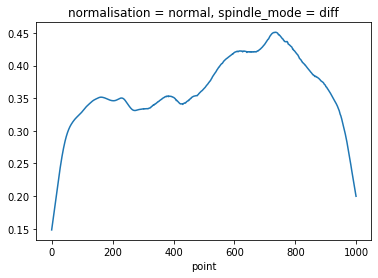

In [16]:
da_all.mean('participant').sel(normalisation = 'normal').loc['diff',11:16,:].mean('freqs').plot.line(x='point')

In [17]:
da = da_all.sel(normalisation = 'normal')

In [18]:
xvline = ratio * 1000
inspi_label_pos = xvline / 2
expi_label_pos = 1000 - ((1000-xvline)/2)

In [19]:
if frontal_spindles_only:
    save_title_append = '_frontal_spindle_only'
else:
    save_title_append = None

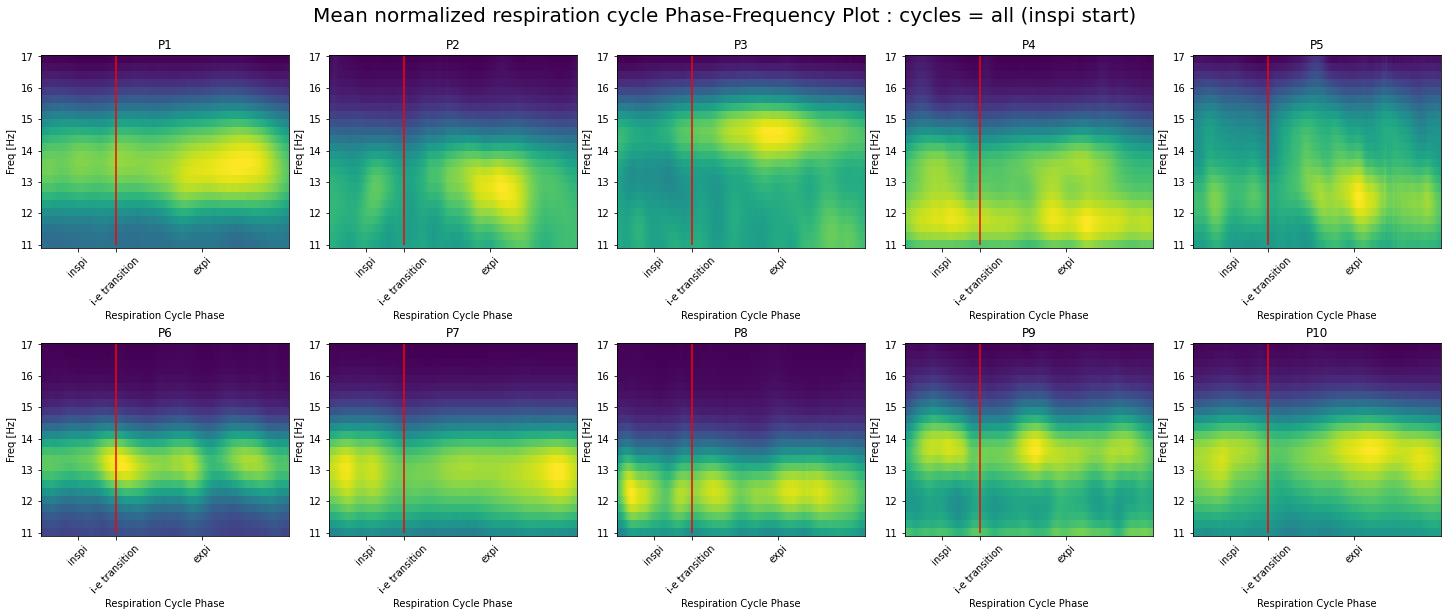

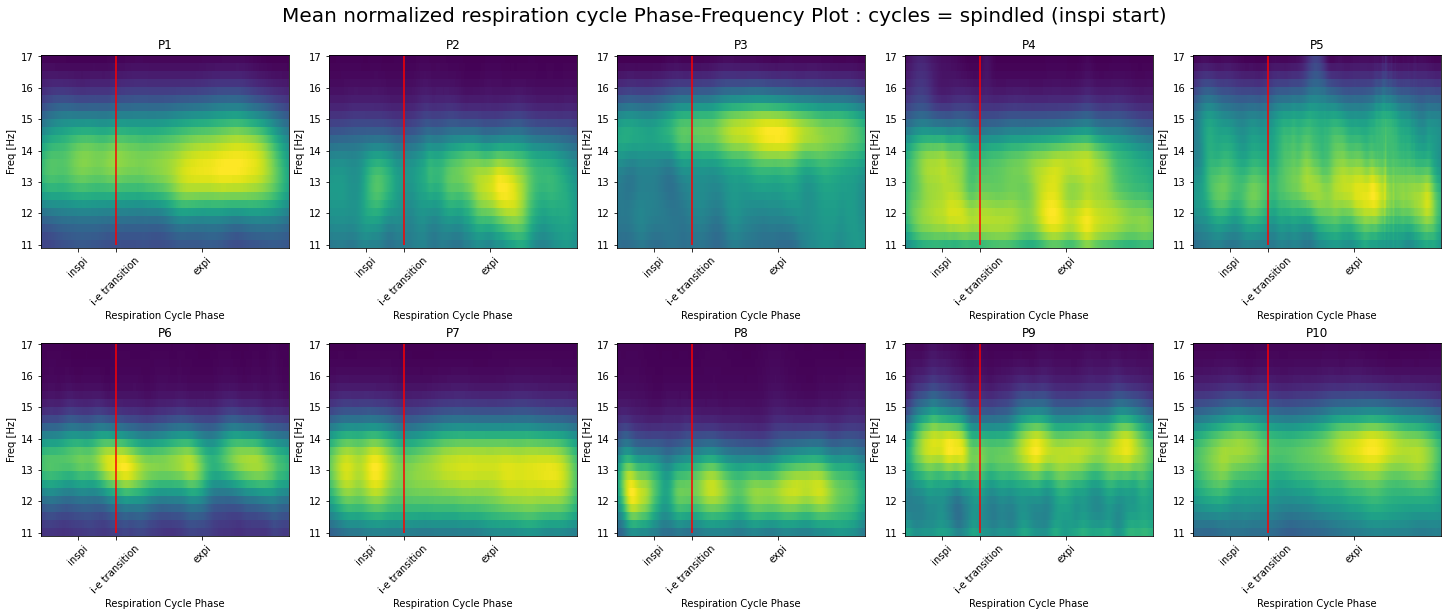

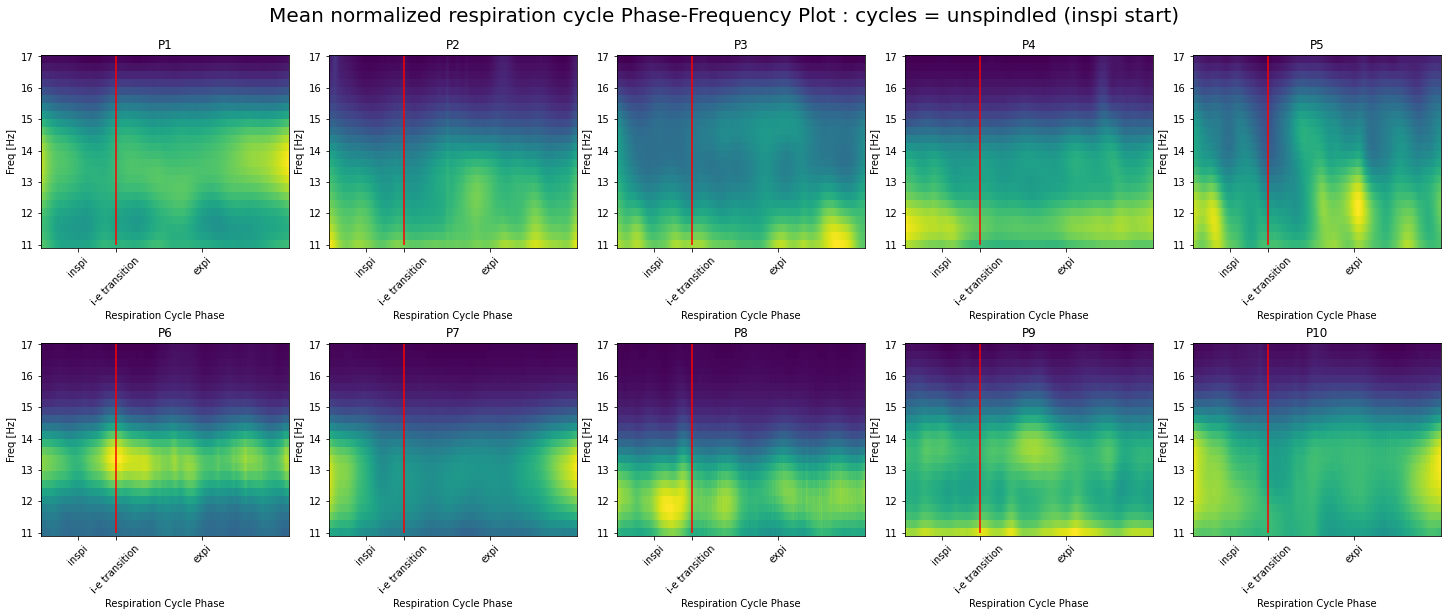

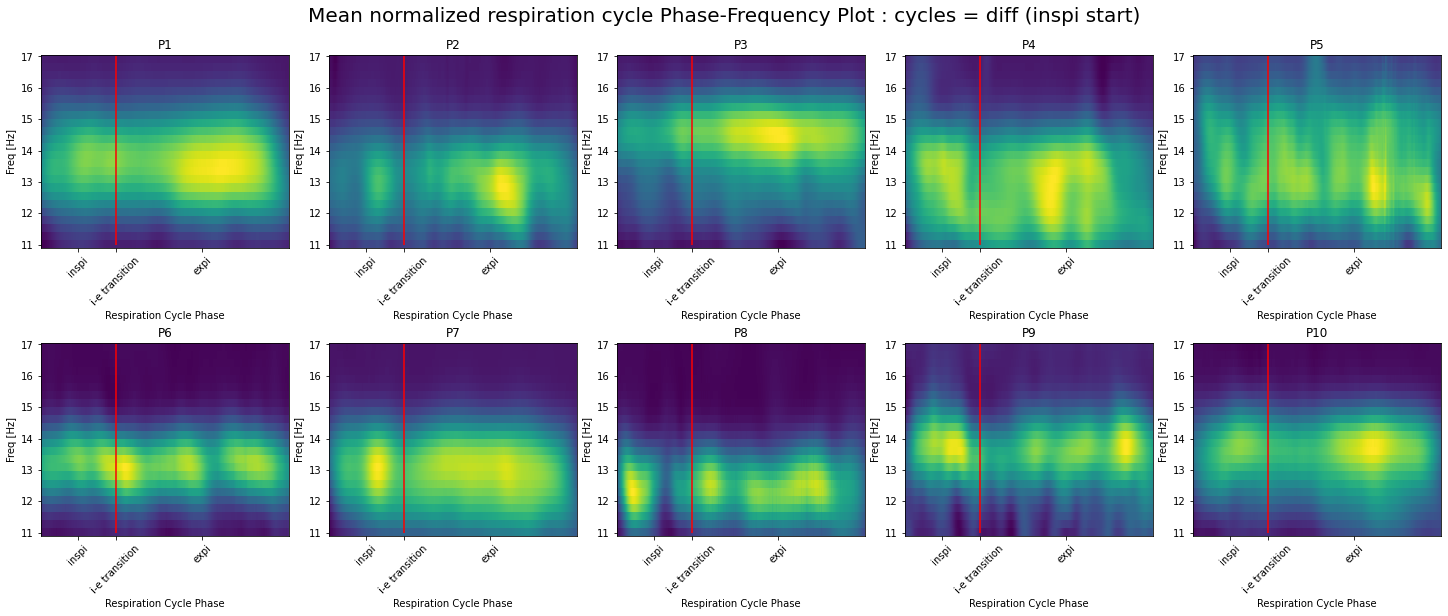

In [20]:
for mode in da.coords['spindle_mode'].values:
    fig, axs = plt.subplots(ncols = 5, nrows = 2, constrained_layout = True, figsize = (20,8))
    fig.suptitle(f'Mean normalized respiration cycle Phase-Frequency Plot : cycles = {mode} (inspi start)', fontsize = 20, y = 1.05)
    for row, sublists in enumerate([ patients[:5] , patients[5:] ]): 
        for col, patient in enumerate(sublists):
            ax = axs[row, col]
            min_freq = 11
            max_freq = 17
            data = da.loc[patient, mode , min_freq:max_freq,:].values
            ax.pcolormesh(da.coords['point'], da.coords['freqs'].loc[min_freq:max_freq], data)
            ax.set_title(patient)
            ax.set_ylabel('Freq [Hz]')
            ax.set_xlabel('Respiration Cycle Phase')
            ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
            ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
            ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
    if save:
        plt.savefig(f'../presentation_4/stretch_tf_by_patient_{mode}_inspi_start{save_title_append}', bbox_inches = 'tight')
    plt.show()

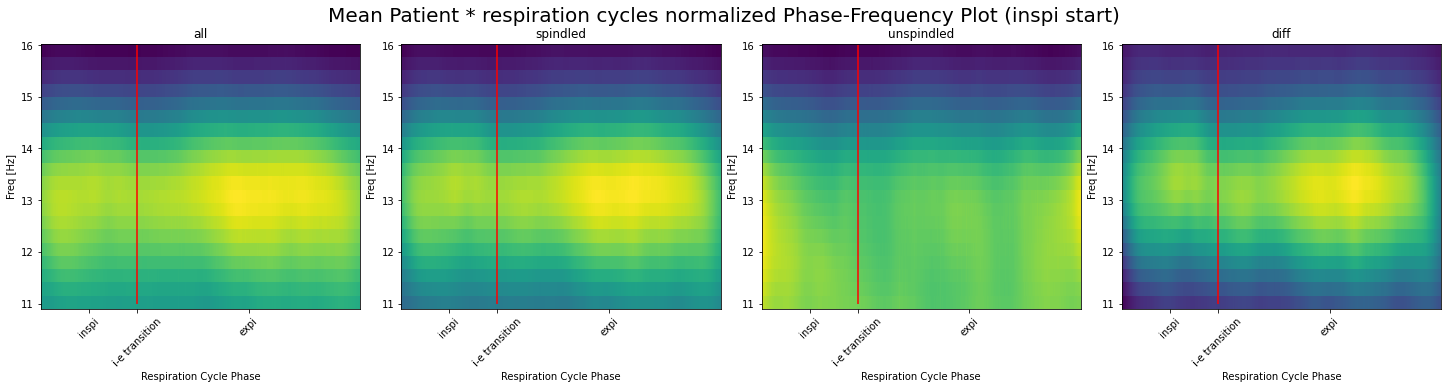

In [21]:
fig, axs = plt.subplots(ncols = 4, constrained_layout = True, figsize = (20,5))
fig.suptitle('Mean Patient * respiration cycles normalized Phase-Frequency Plot (inspi start)', fontsize = 20, y = 1.05)
min_freq = 11
max_freq = 16

for col, mode in enumerate(da.coords['spindle_mode'].values):
    ax = axs[col]
    data = da.loc[:, mode , min_freq:max_freq,:].mean('participant').values
    ax.pcolormesh( da.coords['point'] , da.coords['freqs'].loc[min_freq:max_freq] , data)
    ax.set_title(mode)
    ax.set_ylabel('Freq [Hz]')
    ax.set_xlabel('Respiration Cycle Phase')
    ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
    ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
    ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
if save:
    plt.savefig(f'../presentation_4/stretch_tf_mean_patient_modes_inspi_start{save_title_append}', bbox_inches = 'tight')
plt.show()

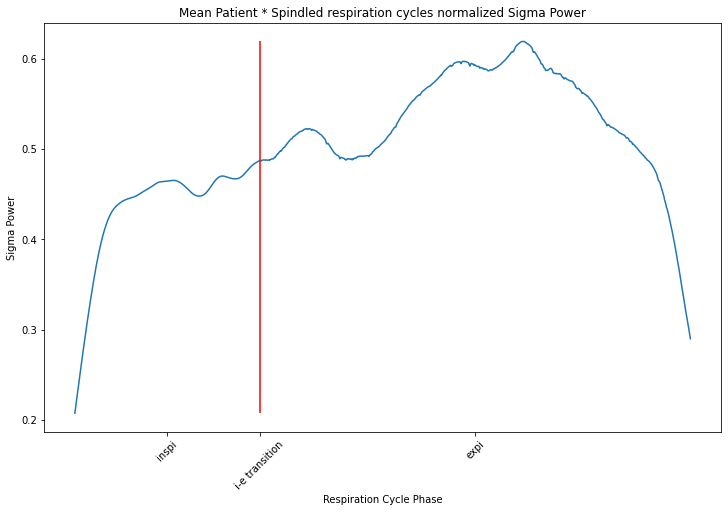

In [22]:
fig, ax = plt.subplots(constrained_layout = True, figsize = (10,7))
min_freq = 12
max_freq = 13
data = da.loc[:, 'diff' , min_freq:max_freq,:].mean(['participant','freqs']).values
ax.plot(da.coords['point'], data)
ax.set_title('Mean Patient * Spindled respiration cycles normalized Sigma Power')
ax.set_ylabel('Sigma Power')
ax.set_xlabel('Respiration Cycle Phase')
ax.vlines(x = xvline, ymin = min(data), ymax=max(data), color = 'r')
ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
if save:
    plt.savefig(f'../presentation_4/stretch_sigma_power_mean_patient_inspi_start{save_title_append}', bbox_inches = 'tight')
plt.show()